# Prepare Tetris emulator data - balanced

The data recorded while playing the game needs to be checked and cleaned before being used to train a model. In addition, we will ensure that the number of block spawn examples is about equal to the number of block fall examples.

In [36]:
import os
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt

from recording import RecordingDatabase

In [3]:
class RecordingFolder:
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            it_files = (file for file in it if file.is_file())
            try:
                entry: os.DirEntry = next(iter(it_files))
                _, self.ext = os.path.splitext(entry.name)
            except StopIteration:
                self.ext = None
            self.highest_index = max((int(Path(file.path).stem) for file in it_files), default=-1)
    
    def __len__(self):
        return self.highest_index + 1
    
    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        return file
    
    def delete_items(self, idxs):
        for idx in idxs:
            file = os.path.join(self.path, f"{idx}{self.ext}")
            os.remove(file)
        self.reindex()
    
    def reindex(self):
        self.recompute_highest_index()
        for i1 in range(self.highest_index+1):
            f1 = os.path.join(self.path, f"{i1}{self.ext}")
            if os.path.exists(f1):
                continue
            for i2 in range(i1+1, self.highest_index+1):
                f2 = os.path.join(self.path, f"{i2}{self.ext}")
                if os.path.exists(f2):
                    os.rename(f2, f1)
                    break
        self.recompute_highest_index()
    
    def recompute_highest_index(self):
        with os.scandir(self.path) as it:
            self.highest_index = max((int(Path(file.path).stem) for file in it if os.path.isfile(file)), default=-1)

In [4]:
folder = RecordingFolder(os.path.join("data", "balanced"))
train_folder = RecordingFolder(os.path.join("data", "balanced", "train"))
test_folder = RecordingFolder(os.path.join("data", "balanced", "test"))
print(f"{folder.path} has {len(folder)} files.")
print(f"{train_folder.path} has {len(train_folder)} files.")
print(f"{test_folder.path} has {len(test_folder)} files.")

data\balanced has 22022 files.
data\balanced\train has 0 files.
data\balanced\test has 0 files.


In [22]:
# Check we can read the files

file = next(iter(folder))
boards = np.load(file)
print(boards)
print(boards.shape)

[[[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 1 1 1 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0

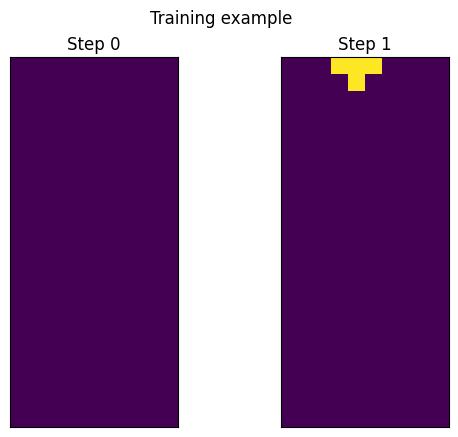

In [6]:
def show_example(file):
    boards = np.load(file)

    fig, axs = plt.subplots(1, len(boards))
    fig.suptitle("Training example")

    for i, ax in enumerate(axs):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"Step {i}")
        ax.imshow(boards[i])

    plt.show()


show_example(file)

Showing example 19973


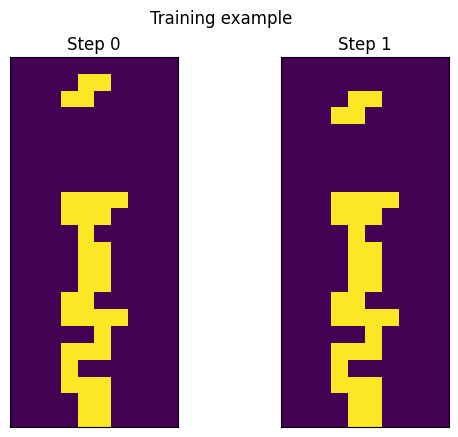

In [20]:
# Show a random example. Run this repeatedly to get an overview of the data.

idx = random.randrange(len(folder))
print(f"Showing example {idx}")
file = folder[idx]
show_example(file)

# Checks

Sanity check the data.

In [24]:
for file in folder:
    boards = np.load(file)
    # Ensure all array elements are 0 or 1
    assert ((boards == 0) | (boards == 1)).all()

# Balance the data

Recorded data tends to have a lot of block fall frames compared to block spawn frames. We will ensure the numbers are roughly equal.

In [25]:
def is_block_spawn(boards):
    return (boards[-2, 0, :] == 0).all() and (boards[-1, 0, :] == 1).any()

In [28]:
spawn_count = 0
fall_count = 0

for file in folder:
    boards = np.load(file)
    if is_block_spawn(boards):
        spawn_count += 1
    else:
        fall_count += 1

print(f"Spawns: {spawn_count} ({spawn_count / len(folder):.2%})")
print(f"Falls: {fall_count} ({fall_count / len(folder):.2%})")

Spawns: 2116 (9.61%)
Falls: 19906 (90.39%)


In [29]:
import random

fall_idxs = [i for i in range(len(folder)) if not is_block_spawn(np.load(folder[i]))]
random.shuffle(fall_idxs)

num_to_delete = fall_count - spawn_count
idxs_to_delete = fall_idxs[:num_to_delete]
folder.delete_items(idxs_to_delete)
fall_count = spawn_count

print(f"{num_to_delete} block fall examples were deleted.")

KeyboardInterrupt: 

In [44]:
del folder
del train_folder
del test_folder

db = RecordingDatabase(os.path.join("data", "balanced"))

spawn_count = 0
fall_count = 0

for boards in db:
    if is_block_spawn(boards):
        spawn_count += 1
    else:
        fall_count += 1

print(f"Spawns: {spawn_count} ({spawn_count / len(db):.2%})")
print(f"Falls: {fall_count} ({fall_count / len(db):.2%})")
assert spawn_count == fall_count

Spawns: 2116 (50.00%)
Falls: 2116 (50.00%)


# Train/test split

We split the data into training and test data in a stratified way between block falls and spawns.

In [46]:
test_split = 0.2
test_count = int(test_split * spawn_count)
train_count = spawn_count - test_count

spawn_idxs = [i for i in range(len(db)) if is_block_spawn(db[i])]
random.shuffle(spawn_idxs)

fall_idxs = [i for i in range(len(db)) if not is_block_spawn(db[i])]
random.shuffle(fall_idxs)

for i in range(train_count):
    old_spawn = os.path.join("data", "balanced", str(spawn_idxs[i]) + db._ext)
    new_spawn = os.path.join("data", "balanced", "train", str(2 * i) + db._ext)
    os.rename(old_spawn, new_spawn)

    old_fall = os.path.join("data", "balanced", str(fall_idxs[i]) + db._ext)
    new_fall = os.path.join("data", "balanced", "train", str(2 * i + 1) + db._ext)
    os.rename(old_fall, new_fall)

for i in range(test_count):
    old_spawn = os.path.join("data", "balanced", str(spawn_idxs[i + train_count]) + db._ext)
    new_spawn = os.path.join("data", "balanced", "test", str(2 * i) + db._ext)
    os.rename(old_spawn, new_spawn)

    old_fall = os.path.join("data", "balanced", str(fall_idxs[i + train_count]) + db._ext)
    new_fall = os.path.join("data", "balanced", "test", str(2 * i + 1) + db._ext)
    os.rename(old_fall, new_fall)

del spawn_idxs
del fall_idxs
del db
print(f"Files split into {train_count} training and {test_count} test examples of each kind.")

Files split into 1693 training and 423 test examples of each kind.


# Post-split checks

Let's check the number of each type of block spawn in both the training and test folder.

In [47]:
import torch
from torch.utils.data import Dataset

class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it), default=-1)

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = torch.tensor(boards[-2]) # Ignore all boards except the last two
        y = torch.tensor(boards[-1], dtype=torch.long)
        return x, y
        

In [49]:
class BlockType:
    I = "I"
    O = "O"
    T = "T"
    Z = "Z"
    S = "S"
    J = "J"
    L = "L"
    All = [I, O, T, Z, S, J, L]
    
def get_block_spawn_type(example):
    x, y = example
    if (x[0, :] == 1).any() | (y[0, :] == 0).all():
        return None
    if (y[1, :] == 0).all():
        return BlockType.I
    if y[0, 3] == 1:
        if y[1, 3] == 1:
            return BlockType.J
        else:
            if y[0, 5] == 1:
                return BlockType.T
            else:
                return BlockType.Z
    else:
        if y[1, 3] == 1:
            if y[0, 4] == 1:
                return BlockType.S
            else:
                return BlockType.L
        else:
            return BlockType.O


def count_block_spawns_by_type(dataset):
    spawns_by_type = {block_type: 0 for block_type in BlockType.All}
    for example in dataset:
        spawn_type = get_block_spawn_type(example)
        if spawn_type is not None:
            spawns_by_type[spawn_type] += 1
    return spawns_by_type


def describe_block_spawns(dataset):
    spawns_by_type = count_block_spawns_by_type(dataset)
    print(spawns_by_type)
    
    num_block_spawns = sum(val for key, val in spawns_by_type.items() if key is not None)
    frac_block_spawns = num_block_spawns / len(dataset)
    print(f"Dataset has {num_block_spawns} block spawns.")


train_dataset = RecordingDataset(os.path.join("data", "balanced", "train"))
test_dataset = RecordingDataset(os.path.join("data", "balanced", "test"))

print("Describing training dataset...")
describe_block_spawns(train_dataset)
print()
print("Describing test dataset...")
describe_block_spawns(test_dataset)

Describing training dataset...
{'I': 221, 'O': 246, 'T': 235, 'Z': 227, 'S': 257, 'J': 251, 'L': 256}
Dataset has 1693 block spawns.

Describing test dataset...
{'I': 47, 'O': 57, 'T': 76, 'Z': 51, 'S': 58, 'J': 74, 'L': 60}
Dataset has 423 block spawns.
